In [1]:
import pandas as pd
from pulp import *

In [4]:
variable_costs=pd.read_excel("variable_costs.xlsx",index_col=0)
variable_costs

,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


In [5]:
storage_costs=pd.read_excel("Storage_costs.xlsx",index_col=0)
storage_costs

,Low,High
Storage Costs ($/unit),,
USA,43.333333,63.333333
Germany,33.200000,48.466667
Japan,41.533333,60.666667
Brazil,21.533333,31.533333
India,14.066667,41.066667


In [16]:
freight_costs=pd.read_excel("freight_costs.xlsx",index_col=0)
freight_costs.dtypes
freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


In [8]:
fixed_costs=pd.read_excel("fixed_cost.xlsx",index_col=0)
fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


In [9]:
carb_emission=pd.read_excel("CO2_Emissions.xlsx",index_col=0)
carb_emission

,USA,Germany,Japan,Brazil,India
CO2 Emissions (kgs),,,,,
USA,0.000000,84.062095,299.317166,125.522063,181.069151
Germany,84.062095,0.000000,267.654340,140.791485,149.307907
Japan,299.317166,267.654340,0.000000,282.624979,127.726291
Brazil,125.522063,140.791485,282.624979,0.000000,191.409089
India,181.069151,149.307907,127.726291,191.409089,0.000000


In [10]:
lead_time=pd.read_excel("Delivery_LeadTime.xlsx",index_col=0)
lead_time

,USA,Germany,Japan,Brazil,India
USA,3,21,65,29,41
Germany,21,3,59,33,34
Japan,65,59,3,62,30
Brazil,29,33,62,3,43
India,41,34,30,43,3


In [17]:
total_cost = freight_costs/1000 + variable_costs 
total_cost

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


In [18]:
total_fixed = fixed_costs + storage_costs
total_fixed

,Low,High
USA,6543.333333,9563.333333
Germany,5013.200000,7318.466667
Japan,6271.533333,9160.666667
Brazil,3251.533333,4761.533333
India,2124.066667,6201.066667


In [22]:
del_delivery=pd.read_excel("Delivery_Deadlines.xlsx",index_col=0)
del_delivery

,USA,Germany,Japan,Brazil,India
USA,30,30,30,30,30
Germany,30,30,30,30,30
Japan,30,30,30,30,30
Brazil,30,30,30,30,30
India,30,30,30,30,30


In [21]:
capacity=pd.read_excel("capacity.xlsx",index_col=0)
capacity

,Low,High
Capacity (kUnits/month),,
USA,500,1000
Germany,500,1000
Japan,500,1000
Brazil,500,1000
India,500,1000


In [24]:
demand=pd.read_excel("demand.xlsx",index_col=0)
demand

,Demand
(Units/month),
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [26]:
delivery_times=pd.read_excel("Delivery_LeadTime.xlsx",index_col=0)
delivery_times

,USA,Germany,Japan,Brazil,India
USA,3,21,65,29,41
Germany,21,3,59,33,34
Japan,65,59,3,62,30
Brazil,29,33,62,3,43
India,41,34,30,43,3


In [23]:
Co2_dict = {'USA':10000000000,'Germany':10000000000,'Japan':10000000000,'Brazil':10000000000,'India':10000000000}
Co2_dict
Co2_Limits  = pd.DataFrame(Co2_dict.items(), columns = ['Country', 'Max CO2 permitted (in kgs)'], )
Co2_Limits.set_index('Country')

,Max CO2 permitted (in kgs)
Country,
USA,10000000000
Germany,10000000000
Japan,10000000000
Brazil,10000000000
India,10000000000


In [33]:
# Define Decision Variables through a list
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     [(i,s) for s in size for i in loc], cat='Binary')
z = LpVariable.dicts("delivery_",[(i,j) for i in loc for j in loc], cat = 'Binary')

# Define Objective Function
model += (lpSum([total_fixed.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([total_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([capacity.loc[i,s]*y[(i,s)] * 1000 for s in size])   
for j in loc:
    model += lpSum([carb_emission.loc[i,j] * x[(i,j)] for i in loc]) <= [5000000000,5000000000,5000000000,5000000000,5000000000]  
    
model += lpSum([delivery_times.loc[i,j] * z[(i,j)] for i in loc for j in loc]) <= (del_delivery.loc[i,j] for i in loc for j in loc)

    
    # Define logical constraint: Add a logical constraint so that if the high capacity plant in USA is open, then a low capacity plant in Germany is also opened.
# model += y[('USA','High_Cap')] <= y[('Germany','Low_Cap')]                                                       
                                                       
# Solve Model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))


# Dictionary to display the output data after optimization:
dict_plant = {}
dict_prod = {}
for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__', '').replace('_', '')
        dict_plant[name] = int(v.varValue)
        p_name = name
    else:
        name = v.name.replace('production__', '').replace('_', '')
        dict_prod[name] = v.varValue
    print(name, "=", v.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/55/9g3gzq3d7ml6qr4n3zbnpwd00000gn/T/72d2f0b23aea4e268cf164f6045d3c04-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/55/9g3gzq3d7ml6qr4n3zbnpwd00000gn/T/72d2f0b23aea4e268cf164f6045d3c04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 232 RHS
At line 249 BOUNDS
At line 285 ENDATA
Problem MODEL has 16 rows, 60 columns and 105 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.07008e+08 - 0.00 seconds
Cgl0004I processed model has 10 rows, 35 columns (10 integer (10 of which binary)) and 60 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.395
Cbc0038I Pass   1: suminf.    0.39500 (2) obj. 1.07008e+08 iterations 0
Cbc0038I Solution found of 1.1656

In [35]:
list_low, list_high = [], []
for l in loc:
    for capacity in ['Low', 'High']:
        x = "('{}','{}')".format(l, capacity)
        if capacity == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')
    
df_capacity

,Low,High
Location,,
USA,1,1
Germany,0,0
Japan,1,1
Brazil,1,0
India,1,1


In [36]:
USA_List, Germany_List, Japan_List, Brazil_List, India_List = [], [], [], [], [] 
for l in loc:
    for variable_costs in ['USA', 'Germany', 'Japan', 'Brazil', 'India']:
        x = "('{}','{}')".format(l, variable_costs)
        if variable_costs == 'USA':
            USA_List.append(dict_prod[x])
        elif variable_costs == 'Germany':
            Germany_List.append(dict_prod[x])
        elif variable_costs == 'Japan':
            Japan_List.append(dict_prod[x])
        elif variable_costs == 'Brazil':
            Brazil_List.append(dict_prod[x])
        elif variable_costs == 'India':
            India_List.append(dict_prod[x])

df_production = pd.DataFrame({'Location': loc, 'USA': USA_List, 'Germany': Germany_List, 'Japan': Japan_List, 'Brazil': Brazil_List, 'India': India_List}).set_index('Location')

df_production

,USA,Germany,Japan,Brazil,India
Location,,,,,
USA,1300000.0,0.0,200000.0,0.0,0.0
Germany,0.0,0.0,0.0,0.0,0.0
Japan,0.0,0.0,1500000.0,0.0,0.0
Brazil,250000.0,0.0,0.0,145000.0,0.0
India,1250000.0,90000.0,0.0,0.0,160000.0


In [37]:
df_production["Sum"] = df_production.sum(axis=1)
df_production

,USA,Germany,Japan,Brazil,India,Sum
Location,,,,,,
USA,1300000.0,0.0,200000.0,0.0,0.0,1500000.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0
Japan,0.0,0.0,1500000.0,0.0,0.0,1500000.0
Brazil,250000.0,0.0,0.0,145000.0,0.0,395000.0
India,1250000.0,90000.0,0.0,0.0,160000.0,1500000.0


In [38]:
sum_list = df_production['Sum']
sum_list

Location
USA        1500000.0
Germany          0.0
Japan      1500000.0
Brazil      395000.0
India      1500000.0
Name: Sum, dtype: float64

In [39]:
low_prod, high_prod = [], []
for i,j,k in zip(list_low, list_high, sum_list):
    if i ==0 and j==1:
        high_prod.append(k)
        low_prod.append(0)
    elif i==1 and j==0:
        low_prod.append(k)
        high_prod.append(0)
    elif i==1 and j==1:
        low_prod.append(500000)
        high_prod.append(k-500000)
    else:
        low_prod.append(0)
        high_prod.append(0)
df_plot = pd.DataFrame({'Location': loc, 'Low': low_prod, 'High': high_prod})
df_plot

,Location,Low,High
0,USA,500000.0,1000000.0
1,Germany,0.0,0.0
2,Japan,500000.0,1000000.0
3,Brazil,395000.0,0.0
4,India,500000.0,1000000.0


# Scenario 1: Standard Conditions

In [40]:
dict_plot1 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[0,0,0,145000,0],'High':[1500000,0,1500000,0,1750000]}
df_plot1 = pd.DataFrame(dict_plot1)
df_plot1

,Location,Low,High
0,USA,0,1500000
1,Germany,0,0
2,Japan,0,1500000
3,Brazil,145000,0
4,India,0,1750000


In [41]:
dict_sce1 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[1300000,0,0,0,1500000],
             'Germany':[0,0,0,0,90000],
            'Japan':[200000,0,1500000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_sce1 = pd.DataFrame(dict_sce1)
df_sce1

,Location,USA,Germany,Japan,Brazil,India
0,USA,1300000,0,200000,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1500000,0,0
3,Brazil,0,0,0,145000,0
4,India,1500000,90000,0,0,160000


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

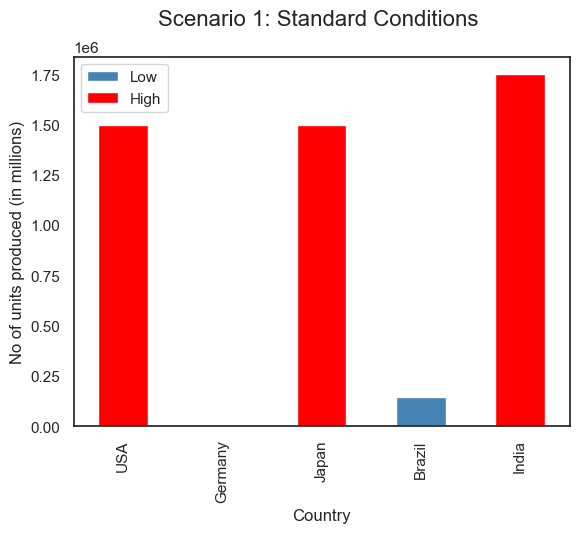

In [43]:
plot_list = []
sns.set(style = 'white')
scen_1 = df_plot1.set_index('Location').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.title('Scenario 1: Standard Conditions \n', fontsize = 16)
plt.xlabel('Country')
plt.ylabel('No of units produced (in millions)')
scen_1
plot_list.append(scen_1)

# Scenario 2: Freight costs increase by 3x due to COVID pandemic

In [44]:
dict_plot2 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[500000,0,500000,145000,0],'High':[1500000,0,1200000,0,1050000]}
df_plot2 = pd.DataFrame(dict_plot2)
df_plot2

,Location,Low,High
0,USA,500000,1500000
1,Germany,0,0
2,Japan,500000,1200000
3,Brazil,145000,0
4,India,0,1050000


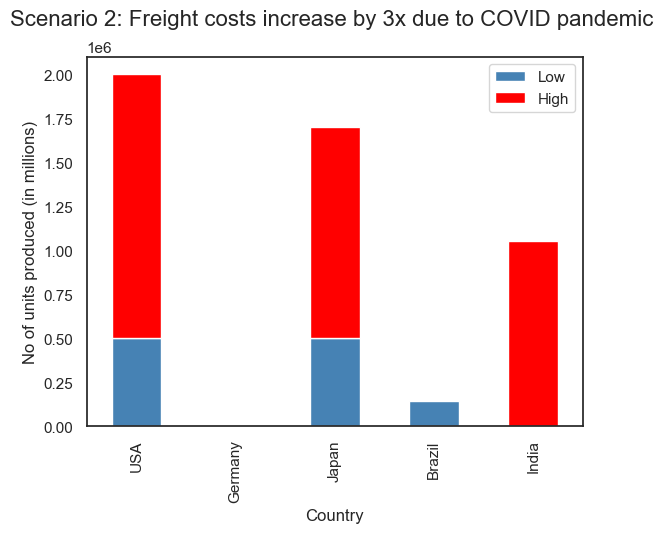

In [45]:
sns.set(style = 'white')
scen_2 = df_plot2.set_index('Location').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.title('Scenario 2: Freight costs increase by 3x due to COVID pandemic \n', fontsize = 16)
plt.xlabel('Country')
plt.ylabel('No of units produced (in millions)')
scen_2
plot_list.append(scen_2)

In [46]:
dict_sce2 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[2000000,0,0,0,800000],
             'Germany':[0,0,0,0,90000],
            'Japan':[0,0,1700000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_sce2 = pd.DataFrame(dict_sce2)
df_sce2

,Location,USA,Germany,Japan,Brazil,India
0,USA,2000000,0,0,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1700000,0,0
3,Brazil,0,0,0,145000,0
4,India,800000,90000,0,0,160000
